## Imports

In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import os

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0


## Misc Utilities

In [2]:
class MAPELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MAPELoss, self).__init__()
        self.eta = 1e-9

    def forward(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true) + self.eta)

        return torch.mean(l)

class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


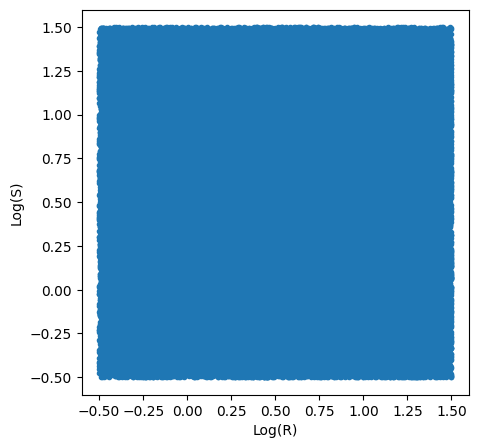

In [3]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 1.5)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


In [4]:
x_scaler = StandardScaler().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train)
y_train = torch.tensor(y_scaled_train)


x_test = torch.tensor(x_scaler.transform(etas_test))
y_test = torch.tensor(y_scaler.transform(gs_test))

## Network Training

In [5]:
# Defining model parameters
checkpoint_dir = './Model_Checkpoints/MCD/'

net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 3,
        "h_dim": 20,
        "dropout": 0.01,
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 0.00001,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 100,
        "device": device,
        "iterator_train__shuffle": True,
        "iterator_train__num_workers": 4,
        "iterator_train__pin_memory": True,
        "iterator_valid__shuffle": False,
        "iterator_valid__num_workers": 4,
        "iterator_valid__pin_memory": True,
        "verbose": 1,
}

In [6]:
test_criteria = RMSELoss()

net_name = 'TurbulenceNetwork_MCD4'

callbacks = [EarlyStopping(patience=15, threshold=0.0001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
        Checkpoint(monitor='valid_loss_best', f_params=net_name+'.pt', dirname=checkpoint_dir),
        LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.0001, threshold_mode='abs', mode='min', verbose=True)
]
train_params['callbacks'] = callbacks


net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
net = net.fit(x_train, y_train)

net.load_params(f_params=checkpoint_dir+net_name+'.pt')
test_pred = net.predict(x_test)

print(f"\t\tTest loss: {test_criteria(torch.tensor(test_pred),y_test)}")

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


/home/codygrogan/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.6260        0.4273     +  1.6346
      2        0.3879        0.3006     +  1.6619
      3        0.2959        0.2348     +  1.6777
      4        0.2355        0.1844     +  1.6540
      5        0.1988        0.1560     +  1.6785
      6        0.1720        0.1315     +  1.5733
      7        0.1466        0.1118     +  1.6951
      8        0.1287        0.0929     +  1.6052
      9        0.1145        0.0792     +  1.6425
     10        0.1039        0.0838        1.6412
     11        0.0946        0.0641     +  1.6844
     12        0.0888        0.0635     +  1.5895
     13        0.0810        0.0547     +  1.6476
     14        0.0720        0.0514     +  1.6054
     15        0.0750        0.0591        1.6589
     16        0.0678        0.0528        1.6448
     17        0.0577        0.0382     +  1.6856
     18        0.0538        0.0346     +  1.6175


In [7]:
test_pred = y_scaler.inverse_transform(net.predict(x_test))

test_loss = MAPELoss()(torch.tensor(test_pred), torch.tensor(gs_test))

print(f"Test loss: {test_loss}")

Test loss: 0.532819019353148


## Reinitializing Trained Model

In [11]:
checkpoint_dir = './Model_Checkpoints/MCD'

net = reinitialize_model('TurbulenceNetwork_MCD2.pt', checkpoint_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


## Generating Statistics Data

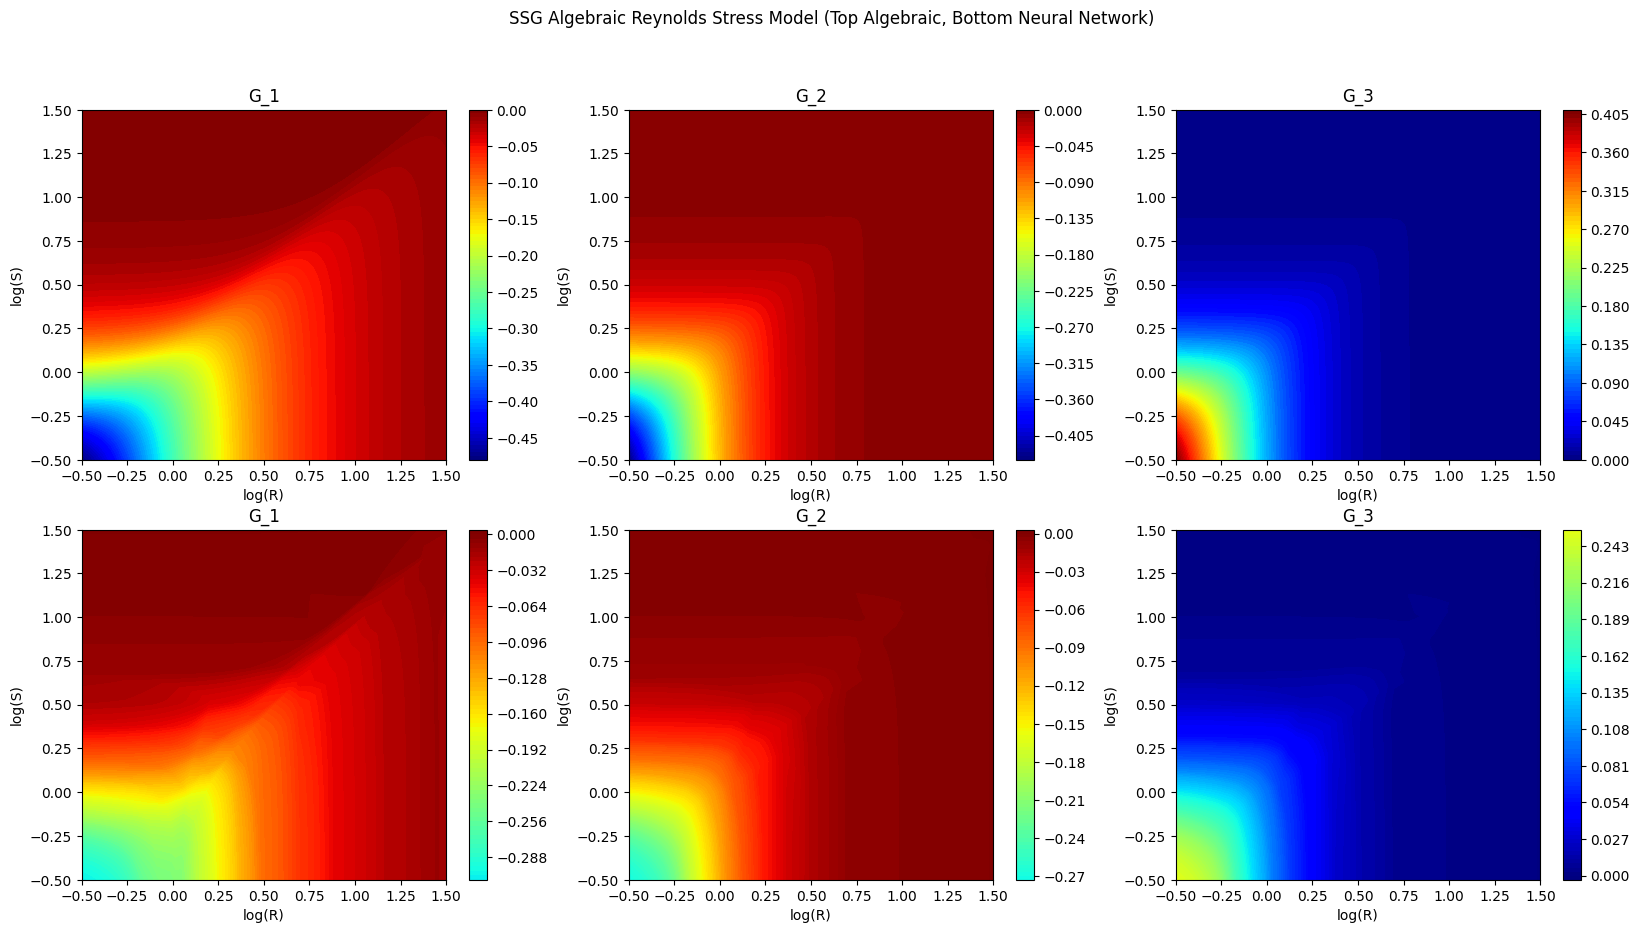

In [12]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

pred = net.predict(etas)

pred = y_scaler.inverse_transform(pred)


pred = pred.T.reshape(3, dim, dim)


plot_heat_map_compare(x_grid, y_grid, target, pred)


## Generating Model Uncertainty From Dropout

In [13]:
T = 150
predictions = np.zeros((T, dim*dim, 3))

batch_size = dim*dim // 2

net.module.dropout_on(net_params['dropout'])

for i in range(T):
    batches = np.zeros((len(etas)//batch_size, batch_size , 3))
    for j in range(len(etas)//batch_size):
        batches[j] = net.module(torch.tensor(etas[j*batch_size:(j+1)*batch_size]).to(device)).cpu().detach()
    predictions[i] = y_scaler.inverse_transform(batches.reshape(dim*dim, 3))
    del batches
    

In [14]:
mean_pred = np.mean(predictions, axis=0)

variance_pred = np.std(predictions, axis=0)

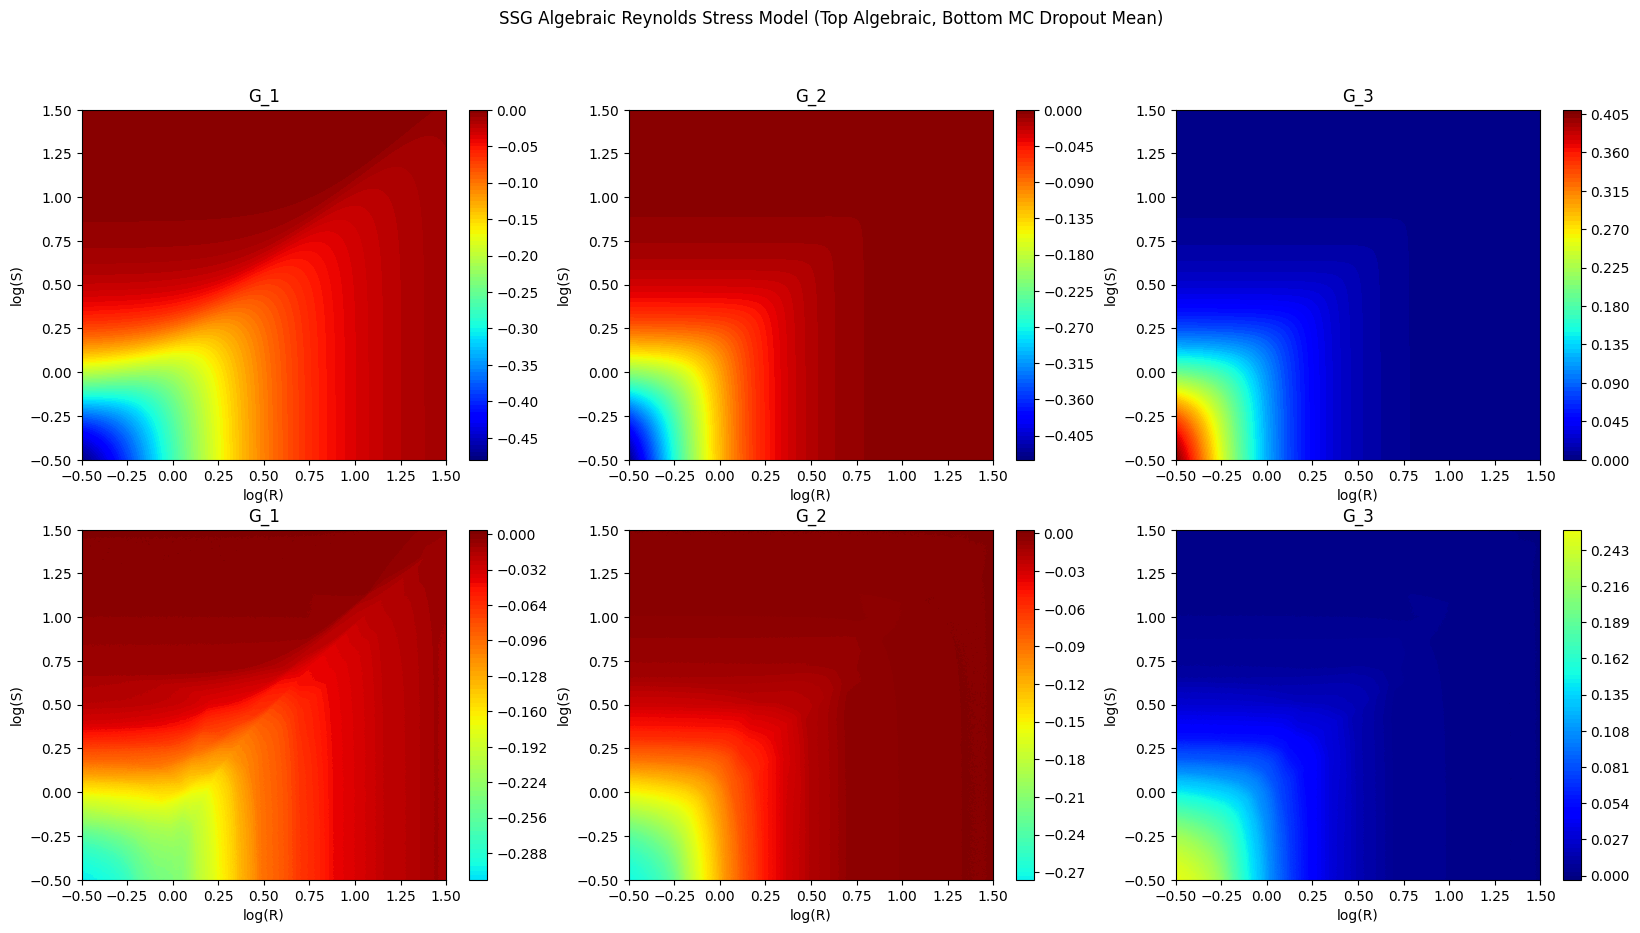

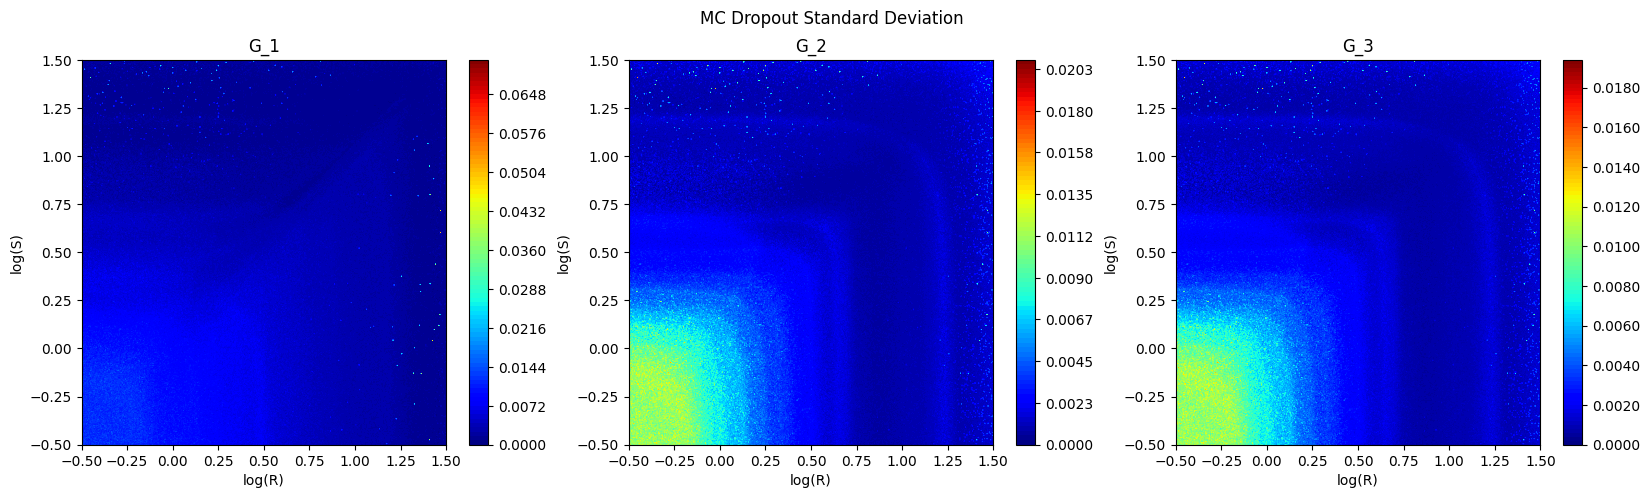

In [15]:

plot_heat_map_compare(x_grid, y_grid, target, mean_pred.T.reshape(3, dim, dim), bottom_title="MC Dropout Mean")

plot_heat_map_3D(x_grid, y_grid, variance_pred.T.reshape(3, dim, dim), title="MC Dropout Standard Deviation")

## Visualizing Different Samples

### Getting Predictions from different networks

In [13]:
names = ['TurbulenceNetwork_MCD1.pt', 'TurbulenceNetwork_MCD2.pt', 'TurbulenceNetwork_MCD3.pt', 'TurbulenceNetwork_MCD4.pt']

T = 75

preds = []
labels = []

for i, name in enumerate(names):
    net = reinitialize_model(name, checkpoint_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    net.module.dropout_on(net_params['dropout'])
    predictions = np.zeros((T, x_test.shape[0], 3))
    for j in range(T):
        predictions[j] = net.module(x_test.to(device)).cpu().detach().numpy()
    preds.append(predictions.reshape(T, -1))
    labels.append(i*np.ones(T))

preds.append(y_test.cpu().detach().flatten().unsqueeze(0).numpy())
labels.append([labels[-1][-1] + 1])

test_outputs = np.concatenate(preds, axis=0)
test_labels = np.concatenate(labels, axis=0)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


### Visualizing

Calculating PHATE...
  Running PHATE on 301 observations and 1800 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.77 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.87 seconds.
  Calculating optimal t...
    Automatically selected t = 7
  Calculated optimal t in 0.04 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.12 seconds.
Calculated PHATE in 1.05 seconds.


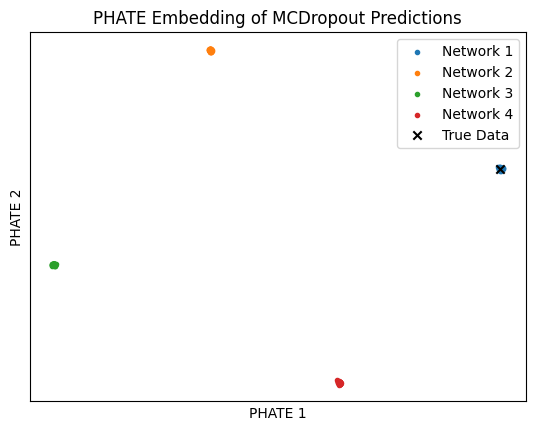

In [16]:
from phate import PHATE

phate_op = PHATE(n_components=2)

phate_output = phate_op.fit_transform(test_outputs)

for i, name in enumerate(names):
    plt.scatter(phate_output[test_labels == i, 0], phate_output[test_labels == i, 1], label=f"Network {i+1}", marker='.')

plt.scatter(phate_output[-1, 0], phate_output[-1, 1], label="True Data", marker='x', color='black')

plt.title("PHATE Embedding of MCDropout Predictions")

plt.xlabel("PHATE 1")
plt.xticks([])

plt.ylabel("PHATE 2")
plt.yticks([])

plt.legend()
plt.show()